## Here we are going to transform real tennis match data into the same format as our mock data.
## The detailed point-by-point data come from Jeff Sackmanns' Match Charting project, so I encourage anyone interested to check out that project, and even contribute. https://github.com/JeffSackmann/tennis_MatchChartingProject . A data science dive this one would not be possible without these data, which do not exist (as far as I can tell) *anywhere else* on the internet. I will be using the file, tennis_MatchChartingProject/charting-m-points.csv ,from that repo.

This work is based on crowdsourced shot-by-shot professional tennis data by The Tennis Abstract Match Charting Project, and is licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License.
Based on a work at https://github.com/JeffSackmann/tennis_MatchChartingProject



In [1]:
filepath = '/home/gmbrandt/Documents/misc_codes/tennis_MatchChartingProject/charting-m-points.csv'

## These data are extremely rich. The columns 1st and 2nd contain how the entire point played out. Because we are just interested in serves, we want to transform column 1 and 2 into one single bite: a 0 or 1 if the first serve went in. 
### We need to do the following things:
1. serve direction is given by: (4 = wide, 5 = body, 6 = down the t; http://www.tennisabstract.com/blog/2015/09/23/the-match-charting-project-quick-start-guide/ ), and the following codes: (n = net, w = wide, d = deep, x = wide and deep), indicate the type of error. So we are interested in situations where the point code is only 2 entries long: things like 4n, 5n, 5w, 6x etc...
2. We need to identify uniquely, for each service point, who is serving. Then we simply need to group by that column later on and then save the full sequence of that persons serves.
3. We are only going to use match data post 2015, just to keep the number of years to a minimum. Players change over time, but many will be roughly consistent over a 2-3 year period (four years is pushing it). If we go longer than that, we will have to split players into their different eras, because e.g., Federer from 2005 is not identical to Federer in 2020. 

In [2]:
import pandas as pd
# match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,
colnames = ['match_id', 'Pt', 'Pts', 'Gm#', 'Svr','Ret','Serving','1st','2nd']
t = pd.read_csv(filepath, usecols=colnames)

In [3]:
from astropy.table import Table 
# switch to astropy tables because of the convenient grouping functions.
tt = Table(t.to_numpy(), names=colnames, dtype=[str, int, str, str, int, int, str, str, str])

In [4]:
# scrub entries where the server is listed as nan -- these were likely improperly tabulated.
tt = tt[tt['Serving'] != 'nan']

In [5]:
tt['date'] = '20220213'
for i in tt:
    split = i['match_id'].split('-M-')
    i['date'] = split[0]

In [6]:
from astropy.time import Time
# remove everything before 2015.
tt = tt[Time([i[:4] for i in tt['date']], format='decimalyear') > Time(2015, format='decimalyear')]

In [7]:
import numpy as np
# Fix the Game number column Gm# . Each entry includes the game number, plus a number in paranthesis, so remove the number in paranthesis.
tt['Gm#'] = np.array([int(i.split('(')[0].strip(' ')) for i in tt['Gm#']], dtype=int)

In [8]:
tt

match_id,Pt,Pts,Gm#,Svr,Ret,Serving,1st,2nd,date
str80,int64,str5,int64,int64,int64,str3,str179,str136,str8
20220213-M-Rotterdam-F-Stefanos_Tsitsipas-Felix_Auger_Aliassime,1,0-0,1,1,2,ST,6n,6d,20220213
20220213-M-Rotterdam-F-Stefanos_Tsitsipas-Felix_Auger_Aliassime,2,0-15,1,1,2,ST,4d,5b38b39b39b37f28b39b38b39b38b27f1n@,20220213
20220213-M-Rotterdam-F-Stefanos_Tsitsipas-Felix_Auger_Aliassime,3,15-15,1,1,2,ST,4f29f38s39f17f38w#,nan,20220213
20220213-M-Rotterdam-F-Stefanos_Tsitsipas-Felix_Auger_Aliassime,4,30-15,1,1,2,ST,4d,5f38s2d#,20220213
20220213-M-Rotterdam-F-Stefanos_Tsitsipas-Felix_Auger_Aliassime,5,30-30,1,1,2,ST,6n,4f18f2n@,20220213
20220213-M-Rotterdam-F-Stefanos_Tsitsipas-Felix_Auger_Aliassime,6,30-40,1,1,2,ST,6f29f39w#,nan,20220213
20220213-M-Rotterdam-F-Stefanos_Tsitsipas-Felix_Auger_Aliassime,7,0-0,2,2,1,FAA,4f28b38s28f+19l2d#,nan,20220213
20220213-M-Rotterdam-F-Stefanos_Tsitsipas-Felix_Auger_Aliassime,8,15-0,2,2,1,FAA,4b39f27f18f28b28b39b2d@,nan,20220213
20220213-M-Rotterdam-F-Stefanos_Tsitsipas-Felix_Auger_Aliassime,9,30-0,2,2,1,FAA,6x,5s38b19*,20220213


In [9]:
print(np.count_nonzero(['federer' in i['match_id'].lower() for i in tt])//2, 'is about how many serves we expect from Federer in this dataset. This is a sanity check for our grouping later.')
print(np.count_nonzero(['djokovic' in i['match_id'].lower() for i in tt])//2, 'is about how many serves we expect from Djokovic in this dataset. This is a sanity check for our grouping later.')

10671 is about how many serves we expect from Federer in this dataset. This is a sanity check for our grouping later.
9188 is about how many serves we expect from Djokovic in this dataset. This is a sanity check for our grouping later.


### now for the only difficult bit. We need to uniquely identify each server in this data set. This is slightly non trivial because the full name of both players is in match_id and their initials are in 'Serving' . But the match_id is not a standard format string, and the initials are of course not unique player to player.

### We are going to take a semi-hardcoded approach to this, looking for just the top 20 players only and essentially cleaning up the dataset. For the other players, we will just label them as unknown for now.

In [10]:
from astropy.table import vstack
# pull the top 20 players for 2020 and 2015 from https://www.ultimatetennisstatistics.com/rankingsTable
rank_2020, rank_2015 = Table.read('data/Rankings_1.csv'), Table.read('data/Rankings_3.csv')
rank_concat = vstack([rank_2020, rank_2015])
# create a dict that gives, per player, the first and last name and their initials.
players_of_interest = {name: {} for name in set(rank_concat['name'])}
for key, item in players_of_interest.items():
    item['first'] = key.split(' ')[0]
    item['last'] = key.split(' ')[-1]
    item['initials'] = "".join([i[0] for i in key.split(' ')])


In [11]:
#print(players_of_interest)
print(len(players_of_interest), ' players will be searched for in our match data.')
print(len(set([p['initials'] for p in players_of_interest.values()])))
print(len(set([p['last'] for p in players_of_interest.values()])))

33  players will be searched for in our match data.
33
33


In [12]:
def likely_player_name(players_of_interest, database_entry):
    match_id, svr_initials = database_entry['match_id'], database_entry['Serving']
    likely_player = None
    for player, vals in players_of_interest.items():
        if vals['last'].lower() in match_id.lower():
            if vals['initials'][0] in svr_initials and vals['initials'][-1] in svr_initials:
                # this second check correctly assigns who is currently serving in that point.
                likely_player = player
        elif vals['first'].lower() in match_id.lower() and vals['initials'] in svr_initials:
            likely_player = player
    return likely_player

tt['svr_fullid'] = ' '*100
for i in tt:
    svr_fullid = likely_player_name(players_of_interest, i)        
    if svr_fullid is None:
        svr_fullid = 'uncertain'
        """
        if i['Svr'] == 1:
            svr_fullid = i['Serving'] + '_' + split[1].split('_')[0].lstrip('-').rstrip('-')
        elif i['Svr'] == 2:
            svr_fullid = i['Serving'] + '_' + split[1].split('_')[-1].lstrip('-').rstrip('-')
        """
    i['svr_fullid'] = svr_fullid

    
tt = tt[tt['svr_fullid'] != 'uncertain']

## Now that that is done, we just need to identify first serve faults.

In [13]:
tt['first_serve_in'] = 1
fault_codes = ['n', 'w', 'd', 'x']
for i in tt:
    pt_string = i['1st']
    pt_string = pt_string.lstrip(' ').rstrip(' ') # strip any leading or trailing zeros.
    if len(pt_string) == 2:
        if pt_string[1] in fault_codes:
            i['first_serve_in'] = 0


In [14]:
print(len(set(tt['svr_fullid'])))
print(len(set(tt['Serving'])))

33
43


In [15]:
print(len(tt), ' total serves on record')

110962  total serves on record


In [16]:
tt = tt.group_by('svr_fullid')

## Ok, now as a check, we want to see what kind of statistics per player we have achieved. Remember we want at least a few players with 10,000 to 20,000 serves on record. Ideally about 50. Players with less than a few thousand serves on record can be scrubbed.

Roger Federer  has the most serves in this database, at 10127
This number agrees with our rough estimate earlier, so we can be reasonably confident that we grabbed all of his points correctly.


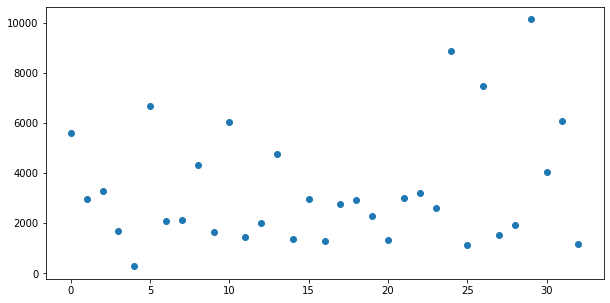

In [17]:
import matplotlib.pyplot as plt
import numpy as np

serves_per_group = []
for i in range(len(tt.groups)):
    serves_per_group.append(len(tt.groups[i]))
serves_per_group = np.array(serves_per_group)

print(tt.groups[np.argmax(serves_per_group)]['svr_fullid'][0], f' has the most serves in this database, at {np.max(serves_per_group)}')
print('This number agrees with our rough estimate earlier, so we can be reasonably confident that we grabbed all of his points correctly.')

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(serves_per_group)), serves_per_group)
plt.show()

## Great! We have a handful of players with > 10,000 serves on record. Let's restrict to those with > 1000, and proceed.

In [18]:
tt_interest_only = tt.groups[np.array(serves_per_group) > 1000]

In [19]:
print(set(tt_interest_only['svr_fullid']))
print('The players we are looking at are:')

{'Grigor Dimitrov', 'Jo Wilfried Tsonga', 'David Goffin', 'Marin Cilic', 'Stan Wawrinka', 'Stefanos Tsitsipas', 'Rafael Nadal', 'Richard Gasquet', 'Milos Raonic', 'Roberto Bautista Agut', 'Karen Khachanov', 'Roger Federer', 'Andrey Rublev', 'John Isner', 'Matteo Berrettini', 'Alexander Zverev', 'Feliciano Lopez', 'Daniil Medvedev', 'David Ferrer', 'Gael Monfils', 'Novak Djokovic', 'Pablo Carreno Busta', 'Tomas Berdych', 'Dominic Thiem', 'Diego Sebastian Schwartzman', 'Kevin Anderson', 'Benoit Paire', 'Gilles Simon', 'Fabio Fognini', 'Kei Nishikori', 'Denis Shapovalov', 'Andy Murray'}
The players we are looking at are:


###  Now we are going to look at each subgroup of players, group by match_id, then sort by point number and save the first_serve_in to a dict, breaking it up by game. Then we can write it out in exactly the same way as our mock data. 

In [20]:
import json

class Data(object):
    def __init__(self, raw_match_data):
        self.serve_data = self.init_serve_data(raw_match_data)

    def init_serve_data(self, raw_match_data):
        player_ids = set(raw_match_data['svr_fullid'])
        serve_data = {}
        for player_id in player_ids:
            serve_data_this_player = []
            match_data_this_player = raw_match_data[raw_match_data['svr_fullid'] == player_id]
            match_data_this_player = match_data_this_player.group_by('match_id')
            for match in match_data_this_player.groups:
                games = match.group_by('Gm#')
                for game in games.groups:
                    game.sort('Pt') # ensure that the points are time-ordered
                    serve_data_this_player.append(game['first_serve_in'].data)
            serve_data[player_id] = serve_data_this_player
        
        return serve_data
    
    def write(self, path):
        # save the serve_data dictionary to disc.
        # convert the data to json serializable ints and lists. Json is human readable and wont restrict other people
        # from using the data, compared to if we wrote out a pickled object.
        for i in self.serve_data.keys():
            self.serve_data[i] = [[int(kk) for kk in list(j)] for j in self.serve_data[i]]
        with open(path, "w") as file:
            json.dump(self.serve_data, file)
            

real_data = Data(tt_interest_only)

In [21]:
real_data.write('formatted_data/first_serve_fault_data.json')

## Woo! OK we are done. Now onto hot_hands_analysis_realdata.ipynb!